- Download the [Raw IMDB dataset](http://mng.bz/0tIo)
- Extract to `../data`

In [1]:
import os

In [34]:
DATA_PATH = '../data'

imdb_dir = os.path.join(DATA_PATH, 'aclImdb')
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            labels.append(int(label_type == 'pos'))

Tokenizing the data

In [35]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [70]:
maxlen = 100
training_samples = 10000
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print "Found {} unique tokens.".format(len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print "Shape of data tensor: {}".format(data.shape)
print "Shape of label tensor: {}".format(labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples:training_samples+validation_samples]
y_val = labels[training_samples:training_samples+validation_samples]

Found 87399 unique tokens.
Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [71]:
DATA_DIR = '../data'
glove_dir = os.path.join(DATA_DIR, 'glove.6B')

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print "Found {} word vectors.".format(len(embeddings_index))

Found 400000 word vectors.


In [72]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector # If word not in embeddings, vector will be all zeros

## Creating a Model

In [73]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [74]:
# Load the Glove
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [75]:
MODEL_PATH = "../models"
# Train and evaluate the model
history = model.fit(x_train, y_train,
                    epochs = 10,
                    batch_size = 32,
                    validation_data=(x_val, y_val)
                   )
model.save_weights(os.path.join(MODEL_PATH, 'pre_trained_glove_model_large_frozen.h5'))

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 127us/step - loss: 0.7114 - acc: 0.4993 - val_loss: 0.6932 - val_acc: 0.4951
Epoch 2/10
10000/10000 [==============================] - 1s 126us/step - loss: 0.6965 - acc: 0.4946 - val_loss: 0.7629 - val_acc: 0.5057
Epoch 3/10
10000/10000 [==============================] - 1s 126us/step - loss: 0.6982 - acc: 0.5024 - val_loss: 0.7189 - val_acc: 0.4966
Epoch 4/10
10000/10000 [==============================] - 1s 126us/step - loss: 0.6885 - acc: 0.5457 - val_loss: 0.7017 - val_acc: 0.4970
Epoch 5/10
10000/10000 [==============================] - 1s 118us/step - loss: 0.6498 - acc: 0.6077 - val_loss: 0.7257 - val_acc: 0.5016
Epoch 6/10
10000/10000 [==============================] - 1s 89us/step - loss: 0.5769 - acc: 0.6927 - val_loss: 0.8053 - val_acc: 0.4974
Epoch 7/10
10000/10000 [==============================] - 1s 86us/step - loss: 0.5004 - acc: 0.7530 - val_loss: 0.8139 - va

# Plots

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt

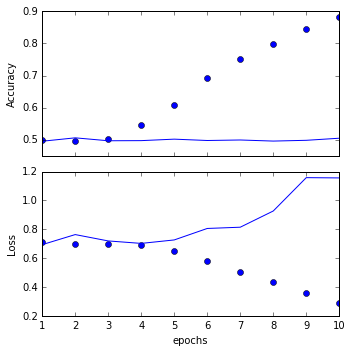

In [77]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(2, 1, figsize=(5, 5), sharex=True)

ax[0].plot(epochs, acc, 'bo', label='Training')
ax[0].plot(epochs, val_acc, 'b', label='Validation')
ax[0].set_ylabel("Accuracy")
# ax[0].set_ylim([0.4, 1.1])

ax[1].plot(epochs, loss, 'bo', label='Training')
ax[1].plot(epochs, val_loss, 'b', label='Validation')
ax[1].set_ylabel("Loss")
ax[1].set_xlabel('epochs')

plt.tight_layout()

# Training without pretraining

In [78]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_6 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(x_train, y_train,
                    epochs = 10,
                    batch_size = 32,
                    validation_data=(x_val, y_val)
                   )
model.save_weights(os.path.join(MODEL_PATH, 'pre_trained_glove_model_full_train_large.h5'))

Train on 10000 samples, validate on 10000 samples
Epoch 1/10
10000/10000 [==============================] - 1s 139us/step - loss: 0.6944 - acc: 0.4994 - val_loss: 0.6932 - val_acc: 0.5019
Epoch 2/10
10000/10000 [==============================] - 1s 128us/step - loss: 0.4222 - acc: 0.8481 - val_loss: 0.8973 - val_acc: 0.5059
Epoch 3/10
 9920/10000 [============================>.] - ETA: 0s - loss: 0.0618 - acc: 0.9849

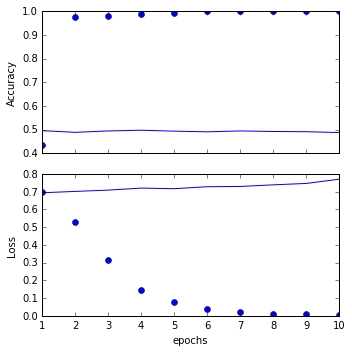

In [63]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, ax = plt.subplots(2, 1, figsize=(5, 5), sharex=True)

ax[0].plot(epochs, acc, 'bo', label='Training')
ax[0].plot(epochs, val_acc, 'b', label='Validation')
ax[0].set_ylabel("Accuracy")
# ax[0].set_ylim([0.4, 1.1])

ax[1].plot(epochs, loss, 'bo', label='Training')
ax[1].plot(epochs, val_loss, 'b', label='Validation')
ax[1].set_ylabel("Loss")
ax[1].set_xlabel('epochs')

plt.tight_layout()

In [64]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname))
            texts.append(f.read())
            f.close()
            labels.append(int(label_type == 'pos'))

In [67]:
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [68]:
model.load_weights(os.path.join(MODEL_PATH, 'pre_trained_glove_model.h5'))
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 2s 62us/step


[0.8707880284500122, 0.5132]